In [196]:
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path

In [197]:
def draw_cue_box(ax, color, alpha):
    #  draw box on plot for cue
    y_lower = ax.get_ylim()[0]
    y_ags_sum = sum(np.abs(ax.get_ylim()))
    rect = patches.Rectangle(
        (0, y_lower), width=5, height=y_ags_sum, alpha=alpha, facecolor=color)
    ax.add_patch(rect)
    return rect


def assign_sex(df, males):
    df = df.with_columns(pl.col('subject').is_in(males).alias('male'))
    return df


males = [3634, 3814, 3816, 3812, 38131]

In [198]:
behavior_path = Path(
    '/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/LHA_dopamine/LH_NAC_Headfix_FP/Photometry/Pav_Training/claire_cohort/analyzed_data/aggregated_data/aggregated_behavior_data.parquet')
fp_path = Path('/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/LHA_dopamine/LH_NAC_Headfix_FP/Photometry/Pav_Training/claire_cohort/analyzed_data/aggregated_data/aggregated_photometry_data.parquet')

In [199]:
bh_df = pl.read_parquet(behavior_path).drop("__index_level_0__").sort('date').sort('subject')


baselines = (bh_df
             .filter(
                 (pl.col('time') <0) 
                 & 
                 (pl.col('time') > -3))
             .group_by(['subject', 'date']).mean()
             .drop(['time', 'time_recorded', 'user'])
             )
baseline_corrected_df = (bh_df
             .join(baselines, on = ['subject', 'date'], how = 'left', suffix = '_baseline')
             .with_columns(
                 (pl.col('encoder_aligned_to_cue') - pl.col('encoder_aligned_to_cue_baseline')).alias('encoder_aligned_to_cue_baseline_corrected'),
                 (pl.col('lick_aligned_to_cue') - pl.col('lick_aligned_to_cue_baseline')).alias('lick_aligned_to_cue_baseline_corrected'),
                 (pl.col('lick_aligned_to_reward') - pl.col('lick_aligned_to_reward_baseline')).alias('lick_aligned_to_reward_baseline_corrected'),
                 (pl.col('encoder_aligned_to_reward') - pl.col('encoder_aligned_to_reward_baseline')).alias('encoder_aligned_to_reward_baseline_corrected')
             )
             .drop(['lick_aligned_to_cue', 'encoder_aligned_to_cue', 'lick_aligned_to_reward', 'encoder_aligned_to_reward', 'lick_aligned_to_reward_baseline', 'encoder_aligned_to_reward_baseline', 'encoder_aligned_to_cue_baseline', 'lick_aligned_to_cue_baseline'])
)
baseline_corrected_df = assign_sex(baseline_corrected_df, males)
baseline_corrected_df

subject,user,date,time_recorded,time,encoder_aligned_to_cue_baseline_corrected,lick_aligned_to_cue_baseline_corrected,lick_aligned_to_reward_baseline_corrected,encoder_aligned_to_reward_baseline_corrected,male
f64,cat,datetime[ns],datetime[ns],f64,f64,f64,f64,f64,bool
117.0,"""User""",2024-02-01 00:00:00,2024-02-15 14:53:30,-10.0,-2.510081,-0.110887,0.252016,0.735887,false
117.0,"""User""",2024-02-01 00:00:00,2024-02-15 14:53:30,-9.805195,-2.1875,-0.272177,0.252016,0.252016,false
117.0,"""User""",2024-02-01 00:00:00,2024-02-15 14:53:30,-9.61039,-2.1875,-0.272177,0.252016,0.574597,false
117.0,"""User""",2024-02-01 00:00:00,2024-02-15 14:53:30,-9.415584,-2.1875,-0.110887,0.252016,0.252016,false
117.0,"""User""",2024-02-01 00:00:00,2024-02-15 14:53:30,-9.220779,-2.1875,0.050403,0.252016,-0.877016,false
117.0,"""User""",2024-02-01 00:00:00,2024-02-15 14:53:30,-9.025974,-1.864919,-0.433468,0.252016,0.090726,false
117.0,"""User""",2024-02-01 00:00:00,2024-02-15 14:53:30,-8.831169,-1.542339,-0.433468,0.090726,-0.070565,false
117.0,"""User""",2024-02-01 00:00:00,2024-02-15 14:53:30,-8.636364,-2.1875,-0.433468,0.252016,-0.393145,false
117.0,"""User""",2024-02-01 00:00:00,2024-02-15 14:53:30,-8.441558,-1.864919,-0.433468,0.252016,-0.877016,false


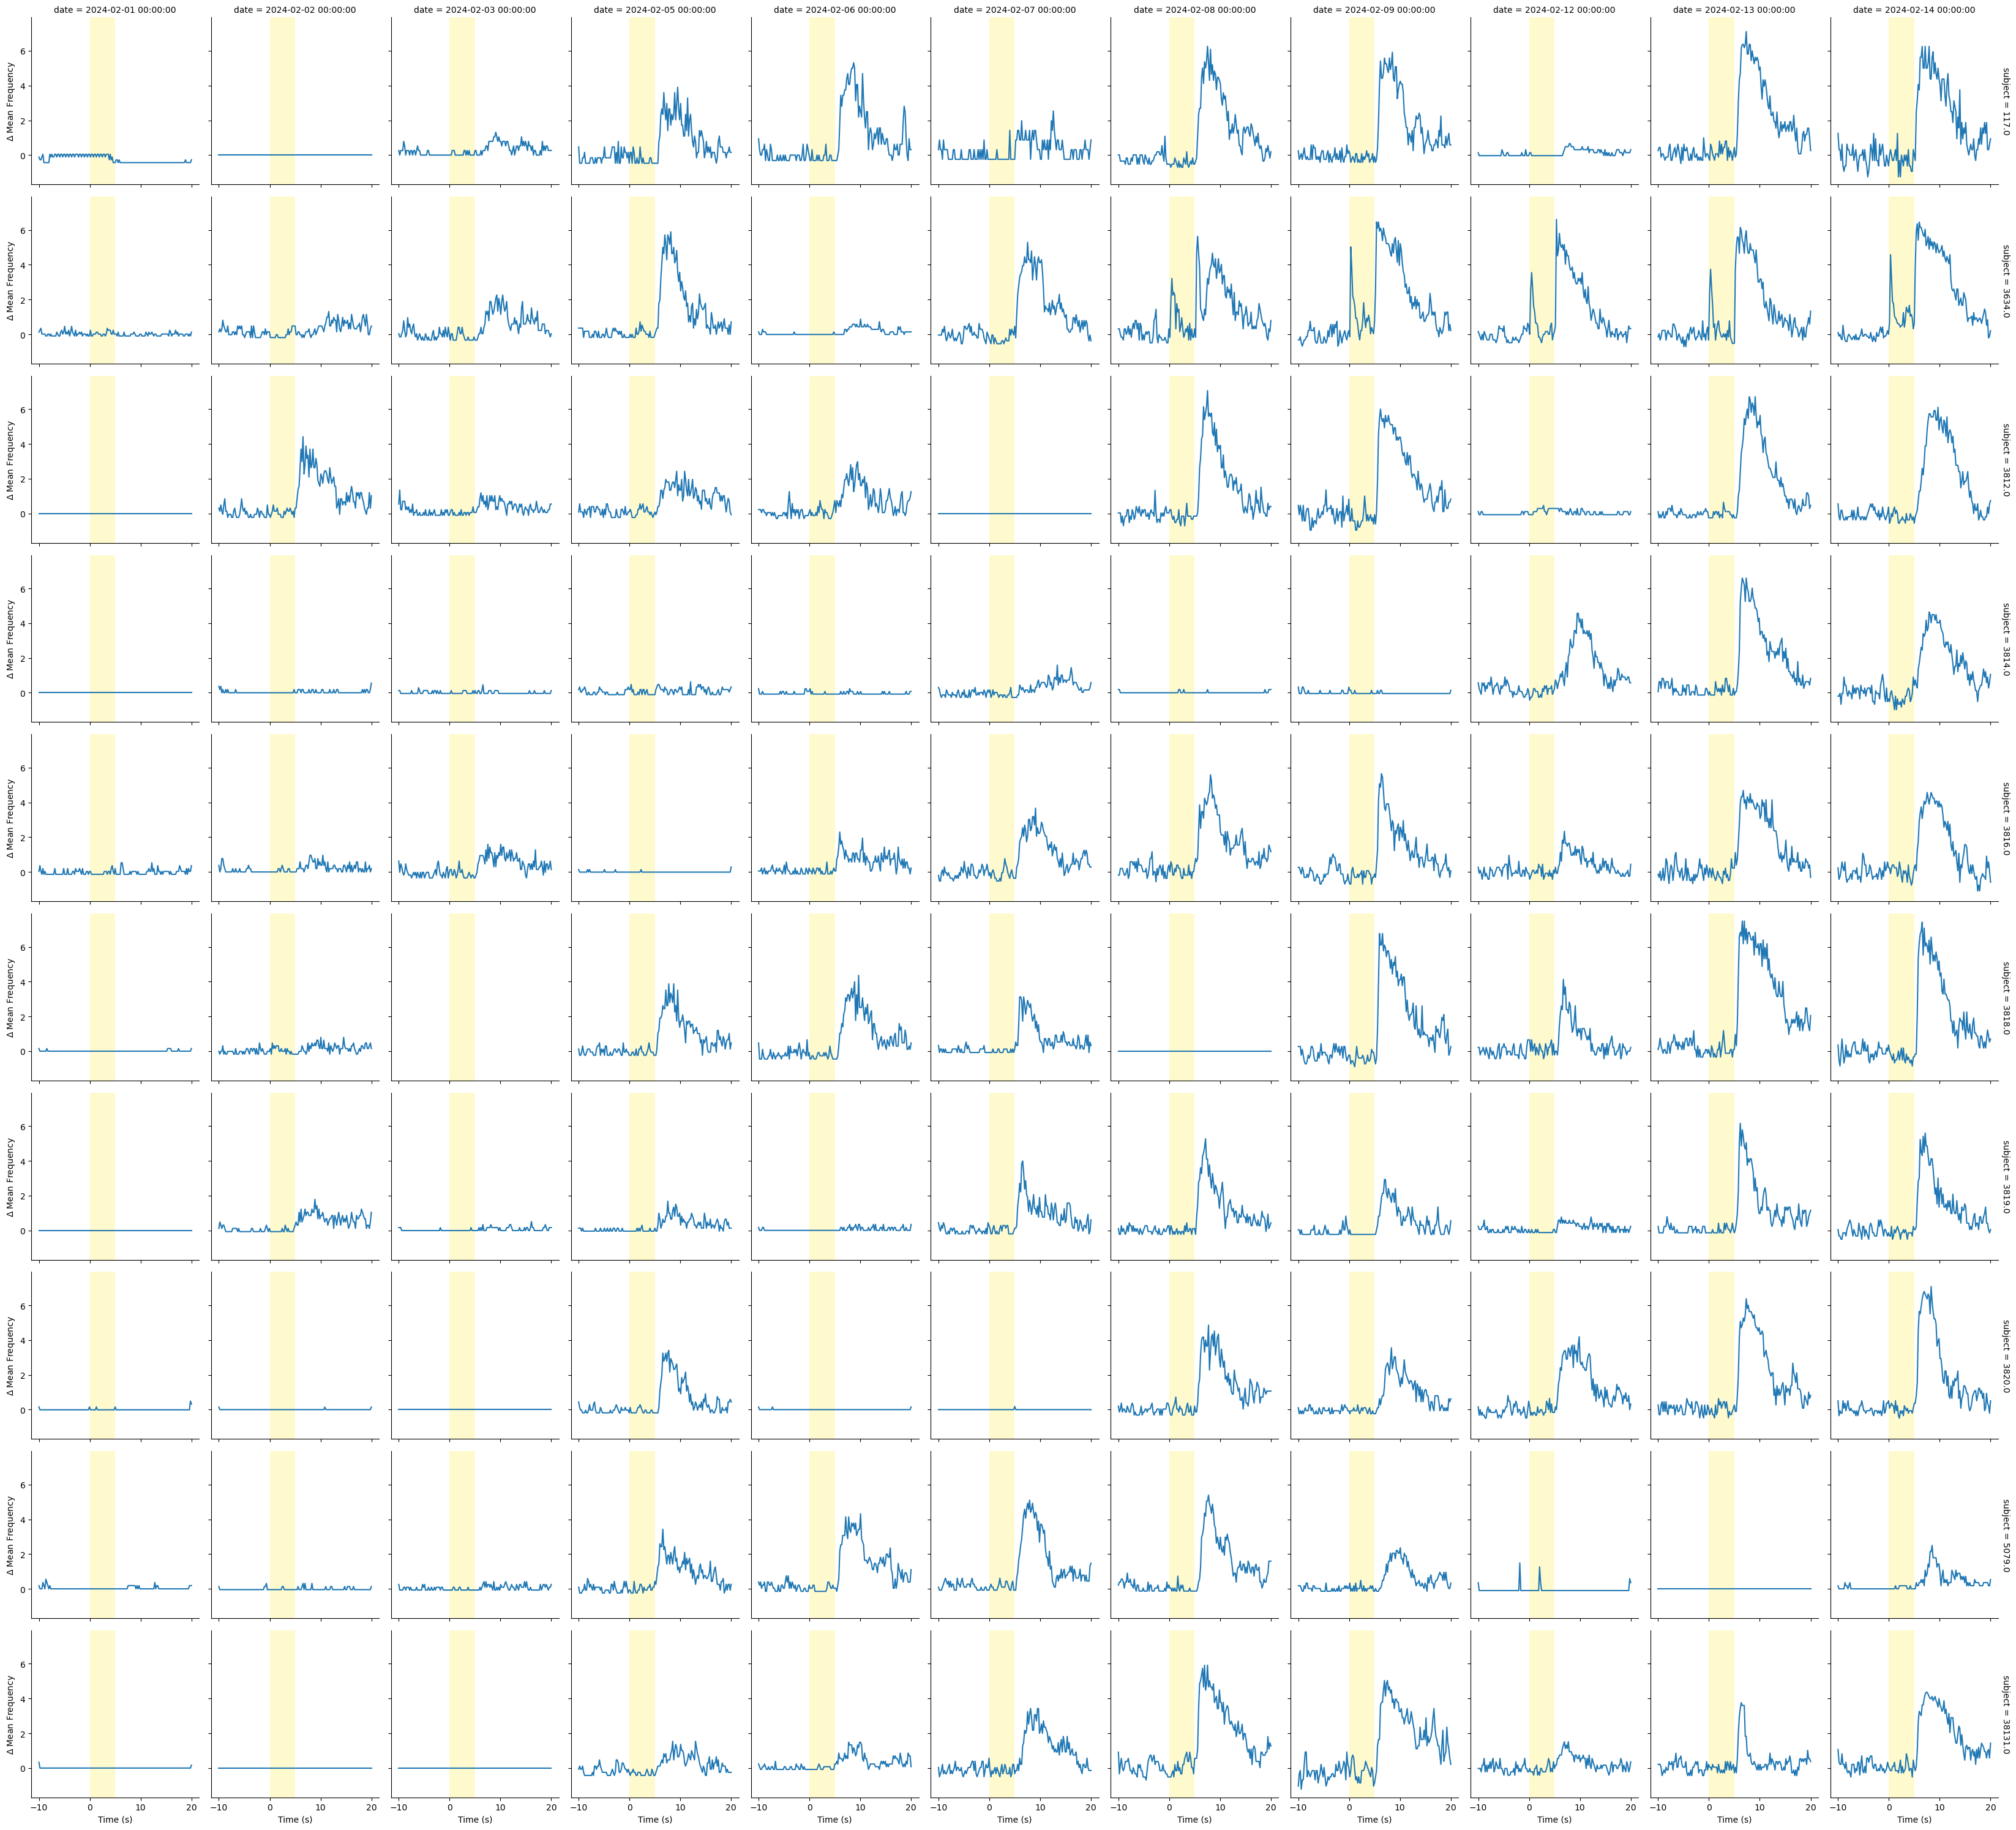

In [200]:
facet = sns.FacetGrid(baseline_corrected_df, col='date', row = 'subject',
                      height=3, aspect=1, margin_titles=True)
facet.map(sns.lineplot, 'time',
          'lick_aligned_to_cue_baseline_corrected')
# facet.map(sns.lineplot, 'time','encoder_aligned_to_cue_baseline_corrected', color = 'grey')
for ax in facet.axes.flat:
    draw_cue_box(ax, color='lemonchiffon', alpha=1)
    ax.set_ylabel(r'$\Delta$ Mean Frequency')
    ax.set_xlabel('Time (s)')
# facet.figure.text(-0.5, 2, 'Lick', color = 'lightblue', size = 20)
    

In [227]:
fp_df = pl.read_parquet(fp_path).drop(
    "__index_level_0__").sort('date').sort('subject')
fp_df = assign_sex(fp_df, males)

grouped = (fp_df
           .drop('time', 'trial', 'user')
           .group_by(*[c for c in fp_df.columns if c not in ['z_score', 'time', 'trial', 'user']])
           .mean()
        )
grouped
# fp_df['subject'].replace('3813', '3813_1')

timestamps,behavioral_events,structures,subject,date,male,z_score
f32,cat,cat,i64,datetime[μs],bool,f32
-8.919127,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,-0.251129
-6.854704,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,-0.252807
-6.461481,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,-0.240939
-3.413999,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,-0.068324
-2.824164,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,-0.061045
-1.841105,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,-0.051281
-1.742799,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,-0.046386
0.616542,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,0.031286
1.501294,"""reward""","""LHA""",117,2024-02-01 00:00:00,false,0.121091


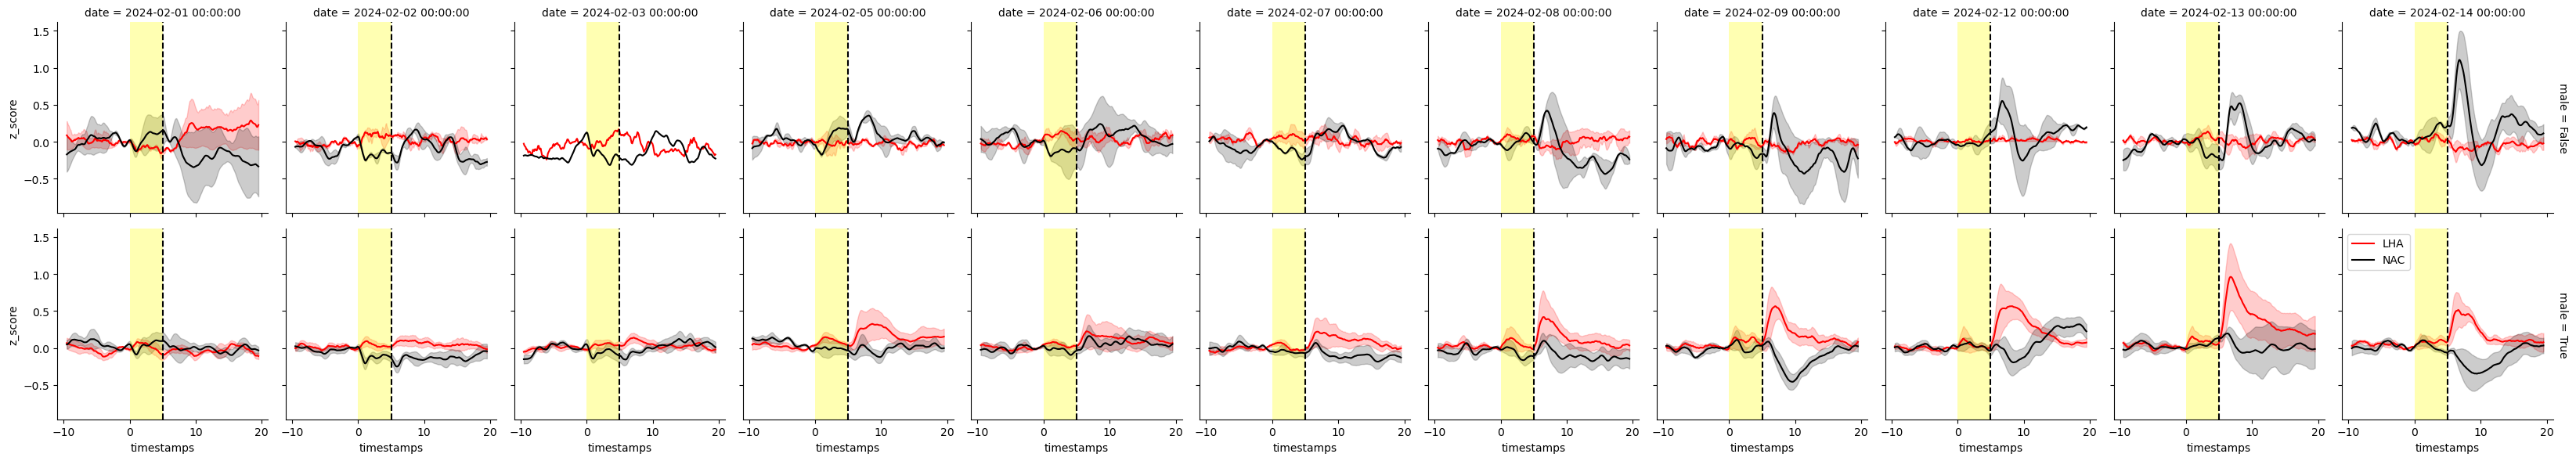

In [228]:
exlude = [5079, 117, 3820]
cue = grouped.filter((pl.col('behavioral_events') == 'cue')
                        &
                        (~pl.col('subject').is_in(exlude)))


facet = sns.FacetGrid(cue, col = 'date', row = 'male', hue = 'structures', palette=['red', 'black'], height = 3, aspect = 1, margin_titles = True)
facet.map(sns.lineplot, 'timestamps', 'z_score', errorbar = 'se')
for ax in facet.axes.flat:
    ax.axvline(5, color = 'black', linestyle = '--')
    draw_cue_box(ax, color = 'yellow', alpha = 0.3)
plt.legend(loc = 'upper left')
plt.tight_layout()

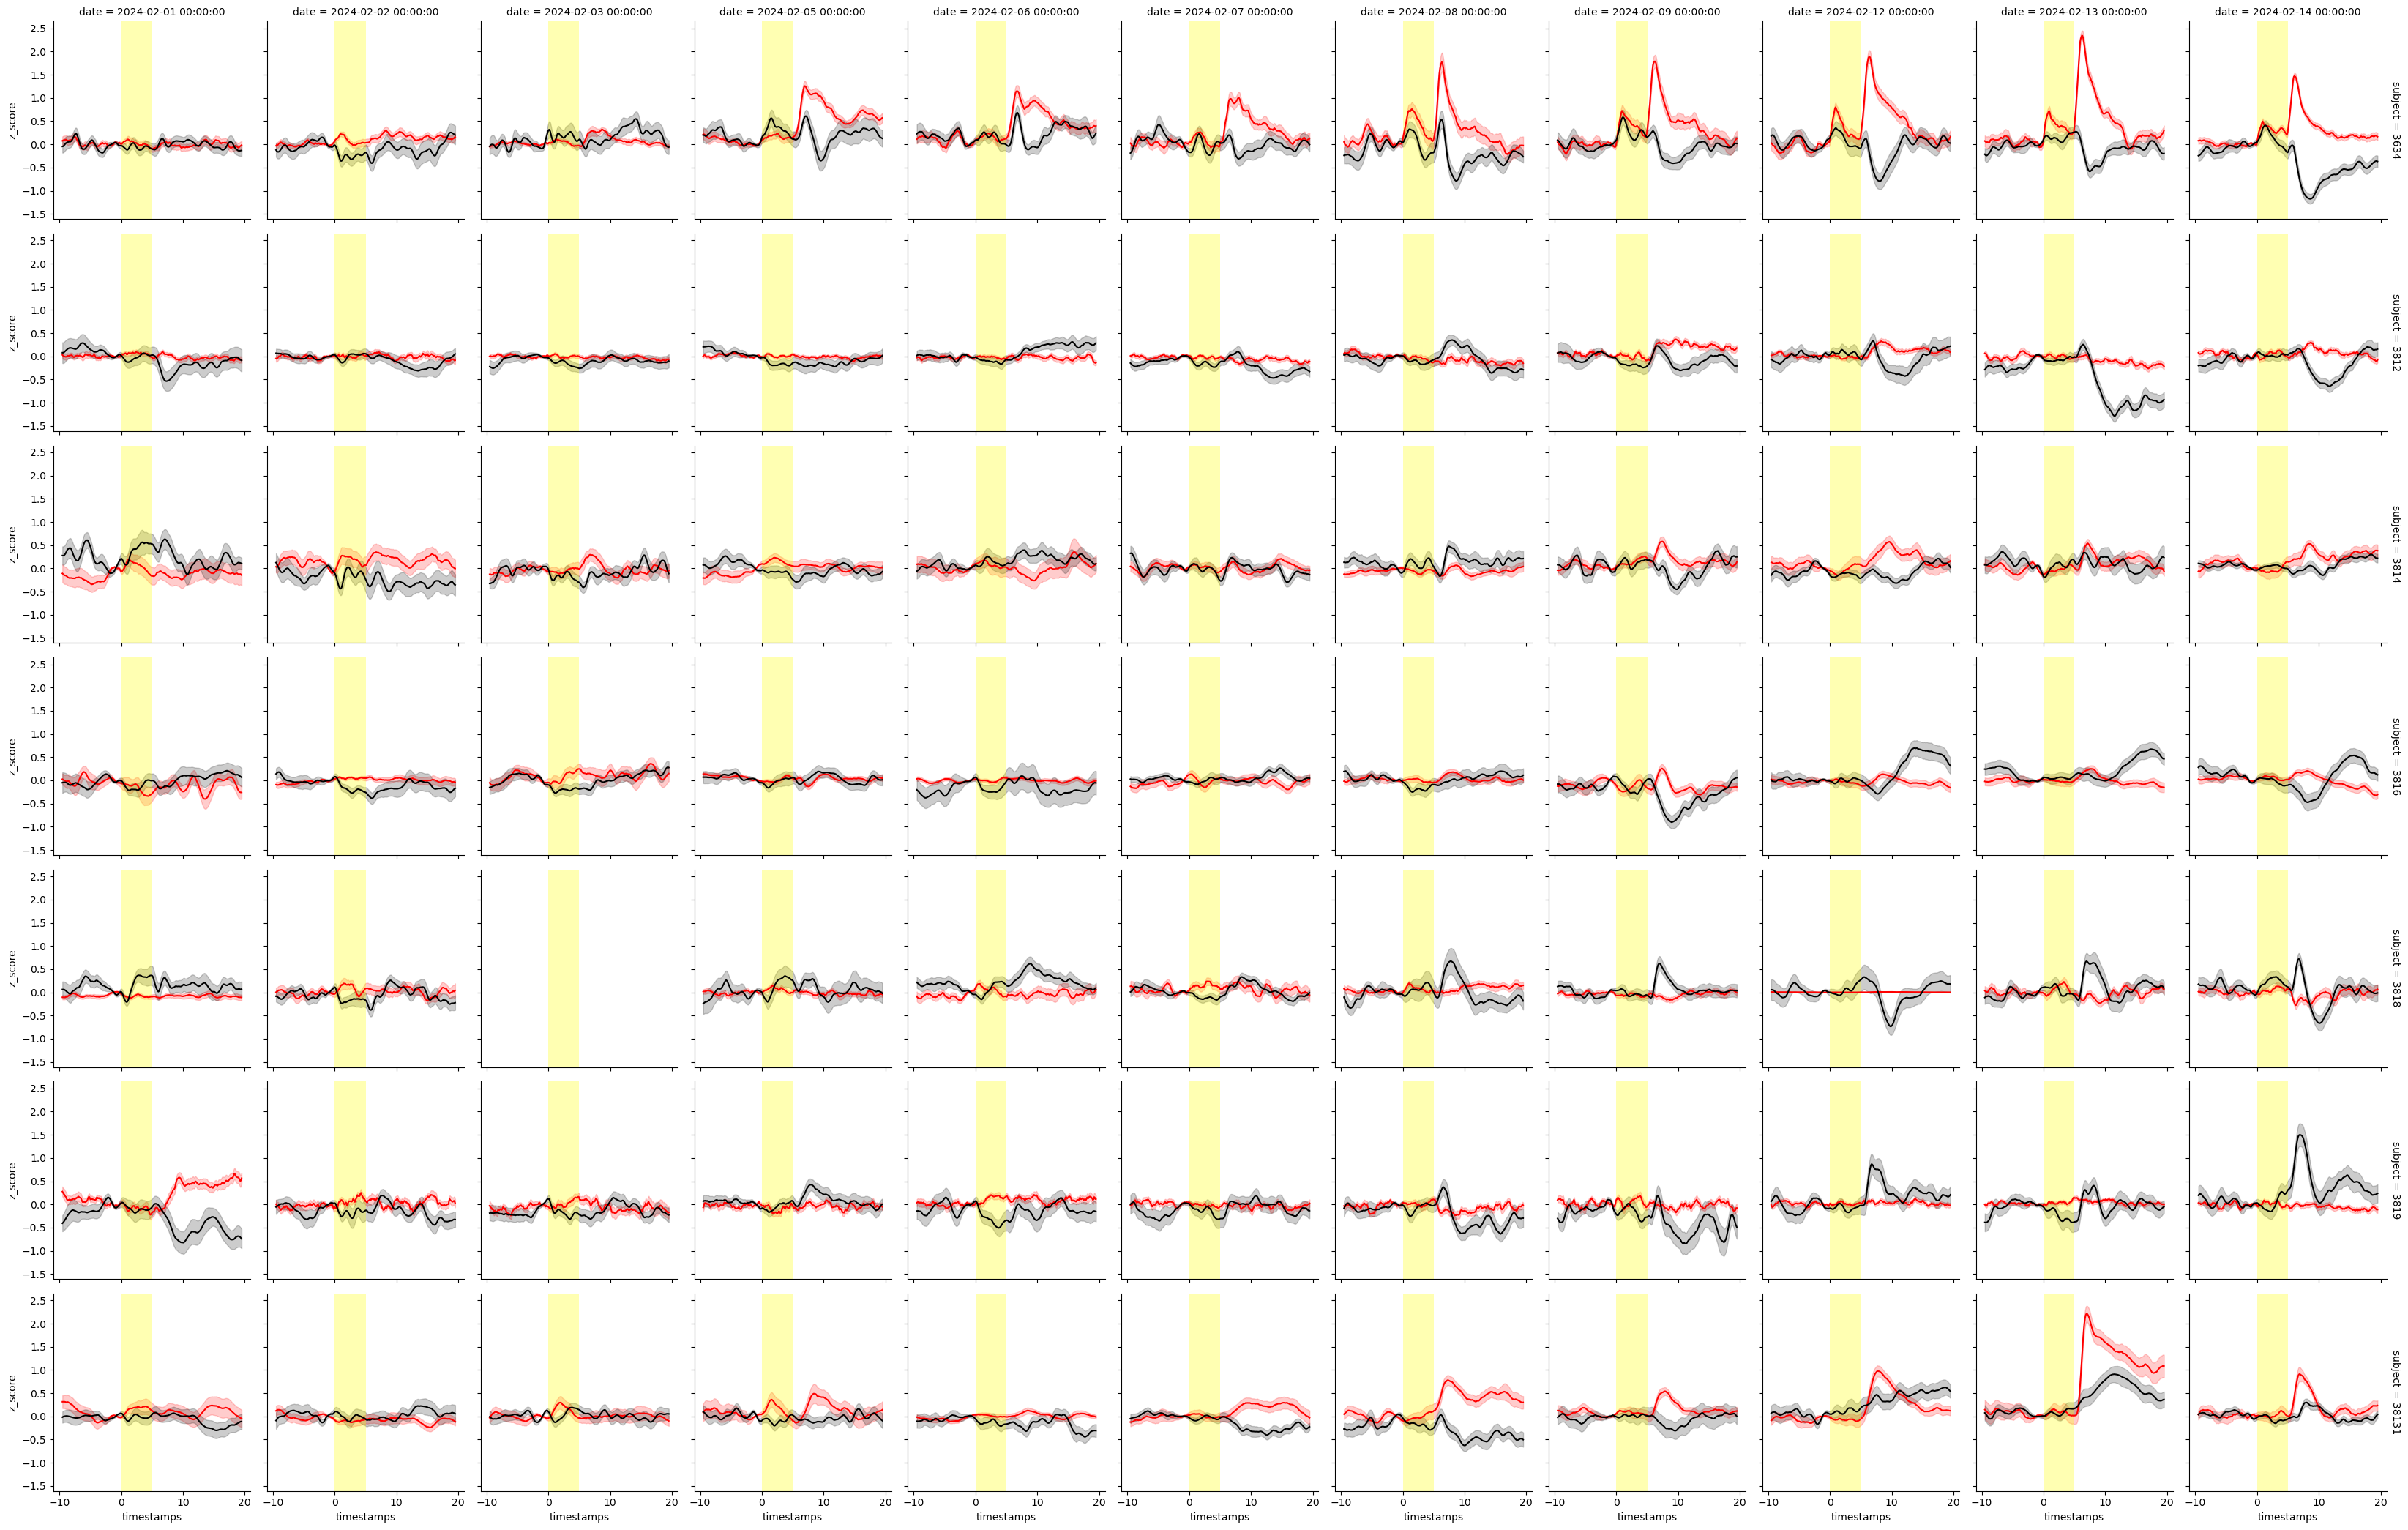

In [186]:

facet = sns.FacetGrid(cue_data, col = 'date',  row='subject',hue = 'structures', palette=['red', 'black'], height=3, aspect=1, margin_titles=True)
facet.map(sns.lineplot, 'timestamps', 'z_score', errorbar='se')
for ax in facet.axes.flat:
    # ax.axvline(0, color='black', linestyle='--')
    draw_cue_box(ax, color = 'yellow', alpha=0.3)
plt.tight_layout()